# CAAI Applied Machine Learning Pre-Doc - Analysis Task

- **Author:** Cameron Raymond
- **Current Affliation:** University of Oxford, Oxford Internet Institute
- **Email:** [cameron.raymond@oii.ox.ac.uk](mailto:cameron.raymond@oii.ox.ac.uk)
- **Github Repo:** [cameron-raymond/CAAI-Pre_Doc-Analysis_Task](https://github.com/cameron-raymond/CAAI-Pre_Doc-Analysis_Task)
- **Purpose:** Demonstrate an understanding of the data wrangling and modelling skills needed to perform research at the University of Chicago's Center for Applied Artificial Intelligence.

<!-- - **Submission link:** https://forms.gle/tagRjeGCQBHVZNiR9 -->

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

## Find the The IMDB-WIKI dataset

IMDB-WIKI dataset can be found [here](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/) and was created by Rothe, Timofte & Van Gool in 2015. It's the largest publicly available dataset of human faces with gender, age, and name. It contains more than 500 thousand+ images with the associated meta information (Rothe, Timofte & Van Gool, 2015 a.):

- `dob`: date of birth (Matlab serial date number)
- `photo_taken`: year when the photo was taken
- `full_path`: path to file
- `gender`: 0 for female and 1 for male, NaN if unknown
- `name`: name of the celebrity
- `face_location`: location of the face. 
- `face_score`: detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image
- `second_face_score`: detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.
- `celeb_names` (IMDB only): list of all celebrity names
- `celeb_id` (IMDB only): index of celebrity name

The original data set is quite unwieldy, but open-sourced code from [`imdeepmind`](https://github.com/imdeepmind/processed-imdb-wiki-dataset) provides a set of python scripts for processing the data. The processed metadata is stored in this project's root directory in the file `meta.csv`.

In [2]:
meta_data = pd.read_csv("meta.csv")[["age","gender","name"]]
meta_data.head()

,age,gender,name
0,41,male,William Baldwin
1,50,male,Keanu Reeves
2,33,male,Ben Stiller
3,31,male,Hannibal Buress
4,17,female,Miley Cyrus


In [3]:
meta_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,523051.0,35.905793,14.435436,-74.0,26.0,34.0,44.0,791.0


## Plot the age distribution of this population, and determine the size of the bucket “15 to 25 years old"

On my first pass there were some notable outliers. First, there were age values that were below 0, which doesn't make sense - as well as some age values that were much older than any human could realistically be. Therefore I decided to remove any values below 5 or above 117 (which according to the [Guinness Book of World Records](https://www.guinnessworldrecords.com/news/2020/10/the-worlds-oldest-people-and-their-secrets-to-a-long-life-632895) is the age of the oldest living human, Kane Tanaka). We could also have set thresholds based on some percentile value, but in the case of a human's age we have reasonable absolute values to use.

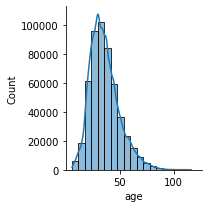

In [7]:
meta_data = meta_data[(meta_data["age"]>5) & (meta_data["age"]<117)] 
plt = sns.displot(meta_data, x="age",binwidth=6,kde=True,height=3)

In [8]:
age_counts = meta_data["age"].value_counts().sort_index()
below_25 = age_counts[(age_counts.index>=15) & (age_counts.index<25)]
print(f"Photos (age 15-25): {below_25.sum()}")

Photos (age 15-25): 88408


## What percentage of this population are "30 year old males"?

In [9]:
males_30 = meta_data[(meta_data["age"]==30) & (meta_data["gender"]=="male")]
num_30_male,total_pop = len(males_30),len(meta_data)
print(f"Number of males aged 30:\t\t{num_30_male}")
print(f"Population size:\t\t\t{total_pop}")
percent_30_and_male = (num_30_male/total_pop)*100
print(f"% of population that's 30 and male:\t{percent_30_and_male:.3f}%")

Number of males aged 30:		10086
Population size:			519773
% of population that's 30 and male:	1.940%


## Using this dataset, how would you build an algorithm that can predict a person's age using their face?

Image data is incredibly nuanced, and it would be difficult to derive features of importance via linear models like a simple OLS regression. Even common non-linear models like a multilayer perceptron (MLP) would likely have trouble with predicting an individual's age as the structure of image data - that is a matrix of pixels with 3 channels for RGB - does not lend itself well to being flattened into a single vector. To better take into account the structure of image data, convolutional neural networks (CNN) have been shown to perform well on a number of computer vision tasks. CNNs differ from traditional MLPs by adding convolutional layers, which apply some set of $m\times n$ filters across the entire image as a sort of sliding window. With each subsequent layer, the filters are able to learn more abstract features of the image. 

The creators of this dataset - Rothe, Timofte & Van Gool - used CNNs to classify the apparent age of individuals in the IMDB-WIKI dataset with a high degree of accuracy. Their CNN architecture won 1st prize in the ChaLearn LAP 2015 challenge on apparent age estimation with 115 registered teams, "significantly outperforming the human reference" (2015 b.). Various CNN architectures and variations have also been applied to the IMDB-WIKI dataset for age estimation with strong results by Qawaqneh et al. (2017) and Huo et al. (2016). Given these robust models for age prediction on this dataset, I would likely choose from one of the various architectures that have already been proposed. This has the advantage of being quicker to implement and has already been validated by third parties.

## What are the tradeoffs of the algorithm you selected? What is the loss function?

CNNs are a powerful model for computer vision problems, and generally outperform linear or tree-based models. This comes from being able to automatically detect relevant features for the given problem. For example, with a CNN we don't have to specify that wrinkles may be a good indicator of someone's age. The model would (hopefully) learn that feature by being exposed to many images of people - some of whom have wrinkles and are generally older, versus others who don't have wrinkles and are generally younger. This is the major benefit of CNNs.

However, this automated feature detection comes at a cost. First, given the number of parameters that CNNs estimate, they lack interpretability. As a result it is hard to say a-priori what features the CNN will learn and use to make its prediction. Some post-hoc tools have shown that when using a CNN to predict whether an image contains a wolf or a husky, the model learned to detect if there was snow in the picture - and if there wasn't the model would predict husky (Ribeiro, Singh, & Guestrin, 2016). Additionally, CNNs are a high-variance model, which means they are prone to overfitting. This is especially true if the dataset used to train the model isn't sufficiently large.

In the case of regression problems, it is common to use mean squared error (MSE) as the model's loss function. Other possible loss functions would be the Kullback-Leibler (KL) divergence, as used by Huo et al, or the mean absolute error (MAE), as used by Rothe, Timofte & Van Gool (2016; 2015 b.).

## Would you trust this algorithm in high stake situations (for instance to detect minors at the airport)? Why/Why not?

Designing an algorithm in a lab, with pre-selected and pre-processed data, is a very different context compared to releasing that algorithm into the world where it will impact peoples' lives. Therefore there are a couple of empirical and theoretical considerations to posit. First we have to define our performance metrics based on the application of the algorithm - and then assuming we have chosen an appropriate model, we have to consider if our training data is a good fit for the classification problem.

First, what is our threshold for false positives versus false negatives? Presumably it is worse to let a child wander unattended at the airport than to mistakenly approach an adult that we classified as an unaccompanied minor. Therefore false negatives are the primary concern in this scenario. This illustrates that while the raw accuracy of a classifier is important - the precision, or in this case recall which we would care more about, are generally more nuanced performance metrics.

Second, just because we can build an image classifier that performs well on its testing data, that does not mean that it will be appropriate for all related image classification problems. Often the difference in performance is a function of the model's training data. Continuing with the IMDB-WIKI dataset and our case - we would have to consider what systematic differences there may be between the images of movie stars/historical figures contained in the dataset, and individuals at an airport. First off, given that celebrities skew white relative to the general population the classifier would likely perform worse on racialized groups. This is a common problem among facial recognition software, an embarrassing and illustrative example of which would be Google Image classifying images of African Americans as ''gorillas'' (Vincent, 2018). Additionally, given that the majority of our dataset contains images of people aged 25-40, as shown by our earlier histogram, a model may not have enough examples of minors to properly work in the wild. For these two reasons I wouldn't recommend using this dataset to classify minors at an airport, regardless of the algorithm.

## Write the algorithm flowchart, and provide a legend explaining each step in the flowchart. How would you train this algorithm? How would you test the algorithm?

![](flowchart.png)

To classify whether someone is an unaccompanied minor we first need to stream in relevant images. This could be from the airport's security cameras. Afterwards it is common to do some preprocessing on the image like increasing or decreasing it's brightness and increasing the contrast. The first thing we care about in this case is whether there are minors in the image, so we would use a CNN to find all the people within the frame and predict if there are any minors. If there are none no further measures are needed. If there are minors we need to determine if they are unaccompanied, which we would use a second model for, this could be based on the distance between the minor and all other people - but it may also need to include temporal aspects to show that they aren't just alone for a second. If the model predicts that they *are* unaccompanied we would then send someone to check that location based on the camera that was used to stream in the data. The important bit is at the end, regardless of whether we sent someone or not, we wait to receive feedback on how the model did and update its parameters. This will help to avoid detrimental feedback loops.

We would first train the model on a relevant dataset (IMDB-WIKI wouldn't be preferable but is an example of one that could be used) and then continuously update the model as it is deployed in the airport. This is similar to transfer learning where the model takes a general problem, like classifying age, and tailors its predictions to its specific context. 

As discussed earlier the choice of performance metrics are important in any modelling process. Given that it is quite harmful to leave a child unattended we would care about the false negative rate (recall) as well as the overall accuracy of the model.

**Sources**

Rothe, R., Timofte, R., & Van Gool, L. (2015). IMDB-WIKI [Data file]. Retrieved from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

Rothe, R., Timofte, R., & Van Gool, L. (2015). Dex: Deep expectation of apparent age from a single image. In Proceedings of the IEEE international conference on computer vision workshops (pp. 10-15).

Qawaqneh, Zakariya, Arafat Abu Mallouh, and Buket D. Barkana. "Deep convolutional neural network for age estimation based on VGG-face model." arXiv preprint arXiv:1709.01664 (2017).

Huo, Z., Yang, X., Xing, C., Zhou, Y., Hou, P., Lv, J., & Geng, X. (2016). Deep age distribution learning for apparent age estimation. In Proceedings of the IEEE conference on computer vision and pattern recognition workshops (pp. 17-24).

Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). " Why Should I Trust You?": Explaining the Predictions of Any Classifier. arXiv preprint arXiv:1602.04938.

Vincent, J. (2018, January 12). Google ‘fixed’ its racist algorithm by removing gorillas from its image-labeling tech. The Verge. Retrieved from https://www.theverge.com